# 使用 TensorBoard 可视化模型，数据和训练

## 在本教程中，我们将学习如何：
> 1. 读取数据并进行适当的转换（与先前的教程几乎相同）。
> 2. 设置 TensorBoard。
> 3. 写入 TensorBoard。
> 4. 使用 TensorBoard 检查模型架构。
> 5. 使用 TensorBoard 来创建我们在上一个教程中创建的可视化的交互式版本，并使用较少的代码

### 具体来说，在第 5 点，我们将看到：
> * 有两种方法可以检查我们的训练数据
> * 在训练模型时如何跟踪其表现
> * 在训练后如何评估模型的表现。

我们将从 ```CIFAR-10``` 教程中类似的样板代码开始：

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


我们将在该教程中定义一个类似的模型架构，仅需进行少量修改即可解决以下事实：图像现在是一个通道而不是三个通道，而图像是 ```28x28``` 而不是 ```32x32``` ：

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

我们将在之前定义相同的 ```optimizer``` 和 ```criterion``` ：

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum =0.9)

## 1. TensorBoard设置
现在，我们将设置 TensorBoard，从 ```torch.utils``` 导入 ```tensorboard``` 并定义 ```SummaryWriter``` ，这是将信息写入 ```TensorBoard``` 的关键对象。

In [4]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

请注意，仅此行会创建一个 ```runs/fashion_mnist_experiment_1``` 文件夹。

## 2. 写入TensorBoard
现在，使用 ```make_grid``` 将图像写入到 TensorBoard 中，具体来说就是网格。

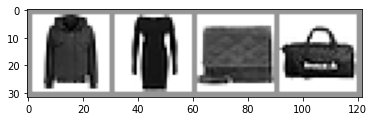

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

正在运行

```
tensorboard --logdir=runs
```

## 3. 使用TensorBoard检查模型
TensorBoard 的优势之一是其可视化复杂模型结构的能力。 让我们可视化我们构建的模型。

In [6]:
writer.add_graph(net, images)
writer.close

<bound method SummaryWriter.close of <torch.utils.tensorboard.writer.SummaryWriter object at 0x000001670545BBE0>>

## 4. 在 TensorBoard 中添加“投影仪”
我们可以通过 <font color = "orange"><u>add_embedding</u></font> 方法可视化高维数据的低维表示

In [7]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()


现在，在 TensorBoard 的“投影仪”选项卡中，您可以看到这 100 张图像-每个图像 784 维-向下投影到三维空间中。 此外，这是交互式的：您可以单击并拖动以旋转三维投影。 最后，一些技巧可以使可视化效果更容易看到：选择左上方的“颜色：标签”，以及启用“夜间模式”，这将使图像更容易看到

## 5. 使用 TensorBoard 跟踪模型训练
在前面的示例中，我们仅每 *2000 次迭代*打印该模型的运行损失。 现在，我们将运行损失记录到 TensorBoard 中，并通过 ```plot_classes_preds``` 函数查看模型所做的预测。

In [8]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


最后，让我们使用与之前教程相同的模型训练代码来训练模型，但是每 1000 批将结果写入 TensorBoard，而不是打印到控制台。 这是通过 ```add_scalar``` 函数完成的。

此外，在训练过程中，我们将生成一幅图像，显示该批量中包含的四幅图像的模型预测与实际结果。

In [9]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times
                        # 多次循环在数据集上

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        # 获取输入；
        inputs, labels = data

        # zero the parameter gradients
        # 0参数梯度
        optimizer.zero_grad()

        # forward + backward + optimize
        # 前进 +　后退 ＋ 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...
                               # 每一1000迷你批次 
            # ...log the running loss
            # ...记录运行损耗 
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            # 记录显示模型对随机迷你批次的预测的 Matplotlib 图
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')


Finished Training


## 6. 使用 TensorBoard 评估经过训练的模型

In [10]:
# 1\. gets the probability predictions in a test_size x num_classes Tensor
# 2\. gets the preds in a test_size Tensor
# takes ~10 seconds to run
# 1\.获取test_size x num_classes张量中的概率预测
# 2\.在test_size张量中获取捕食
# 运行需要大约 10 秒
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
# 辅助函数
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
# 绘制所有 PR 曲线
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)


现在，您将看到一个PR ```Curves``` 选项卡，其中包含每个类别的精确调用曲线。 继续四处戳； 您会发现在某些类别中，模型的“曲线下面积”接近 100%，而在另一些类别中，该面积更低